# SMC Bootstrap Filtering with Multinomial Resampling

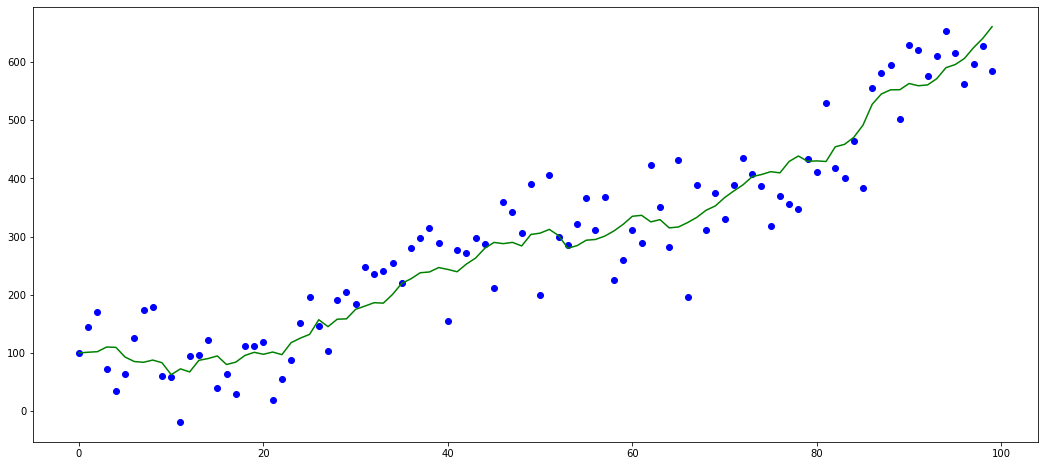

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the number of time steps
T = 100

# Create a time vector
time = np.arange(T)

# Define the state transition parameters
theta = 0.02
state_noise_std = 10
obs_noise = 50


# Observations
Y_real = np.zeros(T)
Y_obs = np.zeros(T)
Y_real[0] = Y_obs[0] = 100
for t in range(1, T):
    Y_real[t] = Y_real[t-1] * np.exp(theta) + np.random.normal(0, state_noise_std) 
    Y_obs[t] = Y_real[t] + np.random.normal(0, obs_noise)

plt.figure(figsize=(18, 8))
plt.plot(time, Y_obs, 'b o', label='Observations')
plt.plot(time, Y_real, 'g', label='Real')
plt.show()

In [3]:
# Define the number of particles
num_particles = 10000

# Initialize arrays to store particle values
particles = np.zeros((num_particles, T))

# Initialize particles with random values
particles[:, 0] = np.random.normal(100, 20, num_particles)

# Perform Bootstrap Filter (Sequential Monte Carlo) with multinomial resampling
for t in range(1, T):
    # State transition step with process noise
    particles[:, t] = particles[:, t - 1] * np.exp(theta) + np.random.normal(0, state_noise_std, num_particles)

    # Likelihood (observation update) with normal likelihood
    particle_likelihood = 1 / np.sqrt(2 * np.pi * obs_noise**2) * \
        np.exp(-0.5 * ((Y_obs[t] - particles[:, t]) / obs_noise)**2)

    # Resampling step (multinomial resampling)
    resample_indices = np.random.choice(np.arange(num_particles), size=num_particles, p=particle_likelihood / np.sum(particle_likelihood))
    particles = particles[resample_indices]

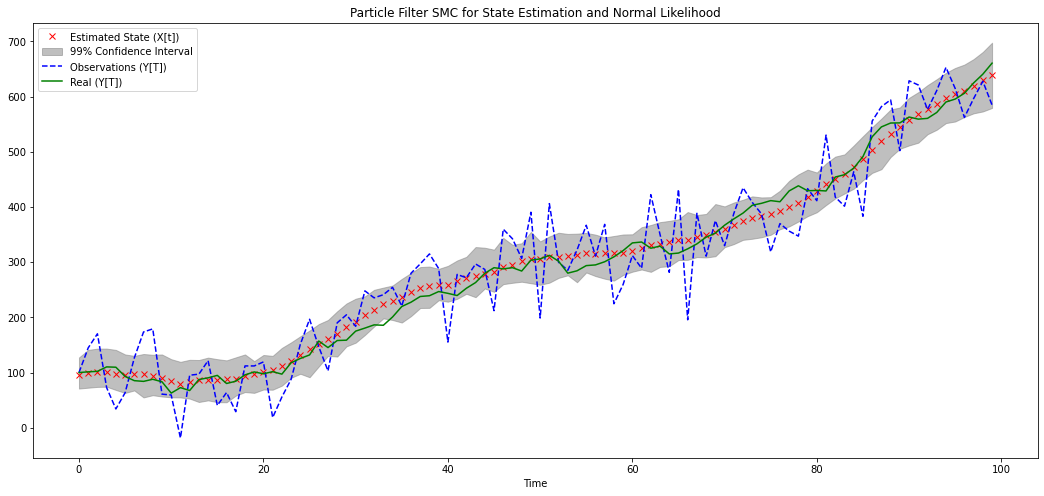

In [4]:
# Calculate the estimated state (X[T]) as the mean of the particles
alpha = 1
estimated_XT_mean = np.mean(particles, axis=0)

# Calculate the 95% probability interval
lower_bound = np.percentile(particles, 0 + alpha/2, axis=0)
upper_bound = np.percentile(particles, 100 - alpha/2, axis=0)

plt.figure(figsize=(18, 8))
plt.plot(time, estimated_XT_mean, 'rx', label='Estimated State (X[t])')
plt.fill_between(time, lower_bound, upper_bound, color='grey', alpha=0.5, label=f'{100-alpha}% Confidence Interval')
plt.plot(time, Y_obs, 'b--', label='Observations (Y[T])')
plt.plot(time, Y_real, 'g', label='Real (Y[T])')

plt.xlabel('Time')
plt.legend()
plt.title('Particle Filter SMC for State Estimation and Normal Likelihood')
plt.show()

# Bootstrap Filter for SIR Toy Model

In [195]:
import pandas as pd

# Define the SIR model
def SUIRD_model(params, t, N):
    alpha, beta, gamma, mu= params
    S0, U0, I0, R0, D0 = N - 10, 10, 0, 0, 0
    S, U, I, R, D = [S0], [U0], [I0], [R0], [D0]

    for i in range(t):
        dS = -(beta * S[-1] * U[-1])/ N
        dU =  (beta * S[-1] * U[-1])/ N - (alpha * U[-1]) - (gamma * U[-1]) - (mu * U[-1])
        dI = alpha * U[-1] - (gamma * I[-1]) - (mu * I[-1])
        dR = gamma * U[-1] + (gamma * I[-1])
        dD = mu * U[-1] + (mu * I[-1])

        S.append(S[-1] + dS)
        U.append(U[-1] + dU)
        I.append(I[-1] + dI)
        R.append(R[-1] + dR)
        D.append(D[-1] + dD)

    return np.array(S), np.array(U), np.array(I), np.array(R), np.array(D)

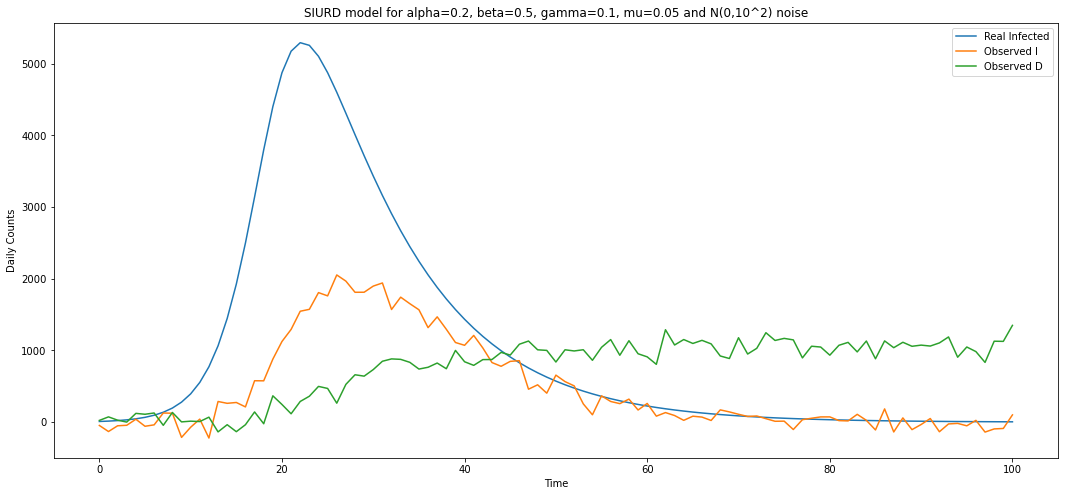

In [240]:
params = (0.08, 0.6, 0.08, 0.01)
T = 100
N = 10000

S,U,I,R,D = SUIRD_model(params,T,N)

I_obs = I + np.random.normal(0,100,T+1)
D_obs = D + np.random.normal(0,100,T+1)

plt.figure(figsize=(18, 8))
plt.plot(np.arange(0,T+1),U+I, label='Real Infected')
plt.plot(np.arange(0,T+1),I_obs, label='Observed I')
plt.plot(np.arange(0,T+1),D_obs, label='Observed D')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Daily Counts')
plt.title('SIURD model for alpha=0.2, beta=0.5, gamma=0.1, mu=0.05 and N(0,10^2) noise')
plt.show()


In [190]:
# Bootstrap Filter for U estimation
num_particles = 1000
num_states = 5

# Initialize particles
particles = np.zeros((num_particles, num_states))
particles[:,0] = np.random.uniform(N-20,N,num_particles)
particles[:,1] = np.random.uniform(0,20,num_particles)
particles[:,2] = np.random.uniform(0,10,num_particles)
particles[:,3] = np.random.uniform(0,10,num_particles)
particles[:,4] = np.random.uniform(0,10,num_particles)

# Initialize weights
weights = np.ones((num_particles,5))

# Define SUIRD transition for 1 step
def SUIRD_step(params, prev_state, N):
    alpha, beta, gamma, mu= params
    S, U, I, R, D = prev_state
    
    dS = -(beta * S * U)/ N
    dU =  (beta * S * U)/ N - (alpha * U) - (gamma * U) - (mu * U)
    dI = alpha * U - (gamma * I) - (mu * I)
    dR = gamma * U + (gamma * I)
    dD = mu * U + (mu * I)
    
    return dS, dU, dI, dR, dD

# Resampling function
def resample(particles, weights):
    num_particles, num_states = particles.shape
    indices = np.arange(num_particles)
    
    # Add a small positive epsilon to weights before resampling
    epsilon = 1e-12
    weights += epsilon
    weights /= np.sum(weights)
    
    # Use numpy's random choice function for 2D arrays
    resampled_indices = np.random.choice(indices, size=num_particles, p=weights)
    
    # Return resampled particles
    return particles[resampled_indices]

#Define initial conditions for transition SIURD model
alpha, beta, gamma, mu = params
S0, U0, I0, R0, D0 = N - 10, 10, 0, 0, 0

S = np.zeros(T)
U = np.zeros(T)
I = np.zeros(T)
R = np.zeros(T)
D = np.zeros(T)
    
# Perform particle filtering
for t in range(T):
    if(t) == 0:
        S[t]= S0
        U[t]= U0
        I[t]= I0
        R[t]= R0
        D[t]= D0
    else:
        S[t] = S[t-1] - (beta * S[t-1] * U[t-1])/ N
        U[t] = U[t-1] + (beta * S[t-1] * U[t-1])/ N - (alpha * U[t-1]) - (gamma * U[t-1]) - (mu * U[t-1])
        I[t] = I[t-1] + alpha * U[t-1] - (gamma * I[t-1]) - (mu * I[t-1])
        R[t] = R[t-1] + gamma * U[t-1] + (gamma * I[t-1])
        D[t] = D[t-1] + mu * U[t-1] + (mu * I[t-1])
        
    # Update particles using the SUIRD model
    particles[:,:] += S[t], U[t], I[t], R[t], D[t]
    # Calculate likelihood with adjusted weights
    likelihood_D = 1 / np.sqrt(2 * np.pi * 10**2) * np.exp(-0.5 * ((D_obs[t] - particles) / 10)**2)
    weights = likelihood_D
    # Normalize weights with epsilon to avoid division by zero
    weights += 1e-12
    weights /= np.sum(weights)
    particles = resample(particles, weights)  # Resampling

    # Store particles in the history array
    particle_history[:, t] = particles

# Calculate the mean at each time step
average_particles = np.mean(particle_history, axis=0)

print("Estimated U (Mean) at each time step:", average_particles)

ValueError: 'p' must be 1-dimensional

<Figure size 864x432 with 0 Axes>

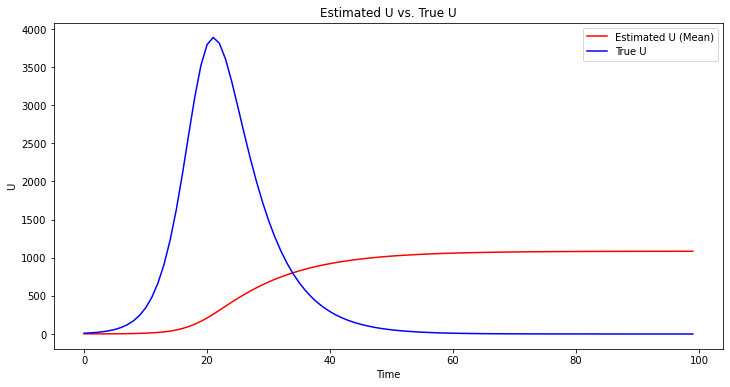

In [171]:
plt.figure(figsize=(12, 6))
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(T), average_particles, label='Estimated U (Mean)', color='red')
plt.plot(range(T), U, label='True U', color='blue')
plt.xlabel('Time')
plt.ylabel('U')
plt.legend()
plt.title('Estimated U vs. True U')
plt.show()

In [231]:
#Define tansition function for the model 
def SUIRD_step(params, prev_state, N):
    alpha, beta, gamma, mu= params
    S, U, I, R, D = prev_state
    
    dS = -(beta * S * U) / N
    dU =  (beta * S * U)/ N - (alpha * U) - (gamma * U) - (mu * U)
    dI = alpha * U - (gamma * I) - (mu * I)
    dR = gamma * U + (gamma * I)
    dD = mu * U + (mu * I)
    
    return dS, dU, dI, dR, dD

# Initialize particles
particles_list = []

particles = np.zeros((num_particles, 5))
particles[:,0] = np.random.uniform(N-100,N,num_particles)
particles[:,1] = np.random.uniform(0,100,num_particles)
particles[:,2] = np.random.uniform(0,100,num_particles)
particles[:,3] = np.random.uniform(0,100,num_particles)
particles[:,4] = np.random.uniform(0,100,num_particles)

particles_list.append(particles)

# Initialize weights
weights_list = []
weights = np.ones(num_particles) / num_particles
weights.append(weights)

#Initialize likelihoods
likelihood_D = []
likelihood_I = []

#Bootstrap Filter SMC (for t=1) 


#Bootstrap Filter SMC (for t >= 1)
for t in range(1,T):
    for i in range(num_particles):
        particles[i,:] += SUIRD_step(params, particles[i,:] ,N)
        #likelihood_I[i] = 1 / np.sqrt(2 * np.pi * 10**2) * np.exp(-0.5 * ((I_obs[t] - particles[i,2]) / 10)**2)
        likelihood_D[i] = 1 / np.sqrt(2 * np.pi * 10**2) * np.exp(-0.5 * ((D_obs[t] - particles[i,4]) / 10)**2)
        weights[i] *= likelihood_D[i]
        
    weights = weights/np.sum(weights)
    indices = np.arange(num_particles)
    resampled_indices = np.random.choice(indices, size=num_particles, p=weights)
    particles = particles[resampled_indices]
    A.append(resample_indices)
    weights = np.ones(num_particles) / num_particles
        
        
        
        
        